XS plotting
===========

This notebook uses the ``pyne.ace`` module to plot cross-sections.
ACE (A Compact ENDF) files are a point-wise representation of cross-section,
considered to be "continuous energy" (as in not discrete) for all practical
purposes.

ACE files originate from processing ENDFs (Evaluated Nuclear Data File) with
some cross section preparation code, such as NJOY.
ACE files already contain some form of approximation compared to ENDFs
(at least some form of doppler broadening, since ACE libraries are for a certain
temperature, and most likely assumptions regarding unresolved resonances and
how to represent them as points, but I would have to check more precisely to
make a strong statement), so in the future I would like to change this to using
ENDF for the plotting and making these assumptions explicit here.

In [489]:
%matplotlib inline

latex = False

if latex:
    import matplotlib as mpl
    mpl.use("pgf")
    pgf_with_rc_fonts = {
        "font.family": "serif",
        "font.serif": [],                   # use latex default serif font
        "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
    }
    mpl.rcParams.update(pgf_with_rc_fonts)

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyne
from pyne import ace
from pyne.data import atomic_mass

mpl.style.use('seaborn')

#if not os.path.isfile("/Users/rodrigo/opt/Serpent2/xsdata/XSdata_jeff311/acedata/54135JEF311.ace"):
#    from urllib import urlretrieve
#    urlretrieve("https://www-nds.iaea.org/wolfram/w180/beta3/W180.ace", "W180.ace")

n_mass = 1.00866491588

ene = 'Neutron energy (MeV)'

xs = '$ \sigma $ (barn)'
xs_t = '$ \sigma_{\mathrm{t}} $ (barn)'
xs_e = '$ \sigma_{\mathrm{e}} $ (barn)'
xs_a = '$ \sigma_{\mathrm{a}} $ (barn)'
xs_f = '$ \sigma_{\mathrm{f}} $ (barn)'
xs_gamma = '$ \sigma_{\gamma} $ (barn)'
xs_alpha = '$ \sigma_{\\alpha} $ (barn)'

nut = '$ \\nu_{\mathrm{t}}$'
eta = '$ \eta $ '

ace_path = "/Users/rodrigo/opt/Serpent2/xsdata/jeff311/acedata/"
ace_end = "JEF311.ace"


def load_ace(nuclide, suffix=ace_end):
    """
    The main class in ``pyne.ace`` is called ``Library``.
    It is instantiated using the name of an ACE file.
    Here we use the files distributed with Serpent.
    """
    lib = ace.Library(ace_path + str(nuclide) + suffix)
    lib.read()
    return lib


def co_alpha(mass):
    return ((mass - n_mass)/(mass + n_mass))**2


def min_collisions(mass, initial_energy=2, final_energy=2.5E-8):
    alpha = co_alpha(mass)
    return np.log(final_energy/initial_energy) / np.log(alpha)


def ln_energy_decrement(mass):
    alpha = co_alpha(mass)
    return 1 + (alpha/(1 - alpha))*np.log(alpha)


def ave_collisions(mass, initial_energy=2, final_energy=2.5E-8):
    xi = ln_energy_decrement(mass)
    return (1/xi) * np.log(initial_energy/final_energy)


def moderating_power(mass, nuclide):
    xi = ln_energy_decrement(mass)
    xse = nuclide.reactions[2].sigma
    return xi * xse


def moderating_ratio(mass, nuclide):
    mod_pow = moderating_power(mass, nuclide)
    xsa = nuclide.reactions[102].sigma
    return mod_pow / xsa


def nu_unionized(nuclide):
    nuclide_nu = np.interp(nuclide.energy, nuclide.nu_t_energy, nuclide.nu_t_value)
    return nuclide_nu


def eta_micro(nuclide):
    nuclide_fission = nuclide.reactions[18].sigma
    nuclide_capture = nuclide.reactions[102].sigma
    nuclide_sigma_a = nuclide_fission + nuclide_capture

    nuclide_FAR = nuclide_fission / nuclide_sigma_a
    nuclide_nu = np.interp(nuclide.energy, nuclide.nu_t_energy, nuclide.nu_t_value)
    nuclide_eta = nuclide_nu * nuclide_FAR
    return nuclide_eta


def save_plot(save):
    if save:
        plt.savefig(f'{save}.pdf', bbox_inches='tight')


def plot_xs(energy, xs, xs_label, lw=0.5, title=None, save=None, ymin=None):
    fig, ax = plt.subplots()
    ax.loglog(energy, xs,linewidth=lw)
    ax.set(xlabel=ene,ylabel=xs_label,title=title)
    ax.set_ylim(ymin=ymin)
    save_plot(save)
    return fig, ax


def plot_semi(energy, semi, semi_label, lw, title):
    fig, ax = plt.subplots()
    ax.semilogx(energy, semi,linewidth=lw)
    ax.set(xlabel=ene,ylabel=semi_label,title=title)
    return fig, ax


def plot_nueta(energy, nueta, ne_label, lw=0.5, title=None, save=None, ymin=None):
    fig, ax = plot_semi(energy, nueta, ne_label, lw, title)
    save_plot(save)
    return fig, ax


def plot_eta(nuclide, lw=0.5, title=None, save=None):
    nuclide_fission = nuclide.reactions[18].sigma
    nuclide_capture = nuclide.reactions[102].sigma
    nuclide_sigma_a = nuclide_fission + nuclide_capture

    nuclide_FAR = nuclide_fission / nuclide_sigma_a
    nuclide_nu = np.interp(nuclide.energy, nuclide.nu_t_energy, nuclide.nu_t_value)
    nuclide_eta = nuclide_nu * nuclide_FAR

    fig, ax = plot_nueta(nuclide.energy, nuclide_eta, eta,
                         lw=lw, title=title)
    save_plot(save)
    return fig, ax


def plot_ratio(energy, ratio, ratio_label, lw=0.5, title=None, save=None, ylim=(-0.05, 1.05)):
    fig, ax = plot_semi(energy, ratio, ratio_label, lw, title)
    ax.set_ylim(ylim)
    save_plot(save)
    return fig, ax


def plot_temperatures(lib, mt, mt_label, lw=0.5, title=None, save=None):
    entries = sorted(lib.tables.keys())
    temperatures = [300, 600, 900, 1200, 1500, 1800]
    fig, ax = plt.subplots()
    for entry, temperature in zip(entries, temperatures):
        if mt == 1:
            __xs = lib.tables[entry].sigma_t
        else:
            __xs = lib.tables[entry].reactions[mt].sigma
        ax.loglog(lib.tables[entry].energy, __xs,
                  # label=f'{temperature: >4d} K',
                  label=f'{temperature} K',
                  linewidth=lw)
    ax.legend()
    ax.set(xlabel=ene,ylabel=mt_label,title=title)
    save_plot(save)
    return fig, ax


def plot_compare_nuclides(nuclides, name_labels, mt, mt_label, lw=0.5, title=None, save=None):
    fig, ax = plt.subplots()
    for nuclide, label in zip(nuclides, name_labels):
        if mt == 1:
            __xs = nuclide.sigma_t
        else:
            __xs = nuclide.reactions[mt].sigma
        ax.loglog(nuclide.energy, __xs,
                  label=label,
                  linewidth=lw)
    ax.legend()
    ax.set(xlabel=ene,ylabel=mt_label,title=title)
    save_plot(save)
    return fig, ax


def plot_compare_mts(nuclide, mts, mt_labels, lw=0.5, title=None, save=None):
    fig, ax = plt.subplots()
    for mt, mt_label in zip(mts, mt_labels):
        if mt == 1:
            __xs = nuclide.sigma_t
        else:
            __xs = nuclide.reactions[mt].sigma
        ax.loglog(nuclide.energy, __xs,
                  label=mt_label,
                  linewidth=lw)
    ax.legend()
    ax.set(xlabel=ene,ylabel=xs,title=title)
    save_plot(save)
    return fig, ax


The main class in ``pyne.ace`` is called ``Library``. It is instantiated using the name of an ACE file, in this case one distributed with Serpent.

In [490]:
H1_mass = atomic_mass('1H')
print(co_alpha(H1_mass))
print(ln_energy_decrement(H1_mass))
print(min_collisions(H1_mass))
print(ave_collisions(H1_mass))

H2_mass = atomic_mass('2H')
print(co_alpha(H2_mass))
print(ln_energy_decrement(H2_mass))
print(min_collisions(H2_mass))
print(ave_collisions(H2_mass))

Be9_mass = atomic_mass('9Be')
print(co_alpha(Be9_mass))
print(ln_energy_decrement(Be9_mass))
print(min_collisions(Be9_mass))
print(ave_collisions(Be9_mass))

C12_mass = atomic_mass('12C')
print(co_alpha(C12_mass))
print(ln_energy_decrement(C12_mass))
print(min_collisions(C12_mass))
print(ave_collisions(C12_mass))

In [ ]:
U235 = load_ace(92235)
U235_12 = U235.tables['92235.12c']

plot_xs(U235_12.energy, U235_12.sigma_t, xs_t,
        title='U-235 total XS at 1200 K', save='U235_1200K')

U235_12_fission = U235_12.reactions[18].sigma

plot_xs(U235_12.energy, U235_12_fission, xs_f,
        title='U-235 fission XS at 1200 K', save='U235_1200K_MT18')

U235_12_capture = U235_12.reactions[102].sigma
U235_12_sigma_a = U235_12_fission + U235_12_capture

plot_xs(U235_12.energy, U235_12_sigma_a, xs_a,
        title='U-235 absorption XS at 1200 K', save='U235_1200K_abs')

plot_nueta(U235_12.nu_t_energy, U235_12.nu_t_value, nut,
           title='U-235 neutron production at 1200 K',
           save='U235_1200K_nu')

In [ ]:
# plot_temperatures(U235, 18, xs_f,
#                   title='Doppler effect on U-235 fission XS')

temperatures = [300, 600, 900, 1200, 1500, 1800]
entries = sorted(U235.tables.keys())

fig, ax = plt.subplots()
for entry, temperature in zip(entries, temperatures):
    ax.loglog(U235.tables[entry].energy, U235.tables[entry].reactions[18].sigma,
              label=f'{temperature} K',
              linewidth=0.5)

ax.legend()
# ax.set_ylim(ymin=0.3)
ax.set(xlabel=ene,ylabel=xs_f,
       title='Doppler effect on U-235 fission XS')


axins = ax.inset_axes([0.05, 0.05, 0.3, 0.3])
for entry, temperature in zip(entries, temperatures):
    axins.loglog(U235.tables[entry].energy, U235.tables[entry].reactions[18].sigma,
                 linewidth=0.3)

axins.set_xlim(1.85E-6, 2.25E-6)
axins.set_ylim(1.1E1, 3E1)
for spine in axins.spines.values():
    spine.set_color('black')
    spine.set_linewidth(0.3)
axins.tick_params(axis='both',
                  which='both',
                  direction='in',
                  color='black',
                  length=2,
                  labelsize=5)
axins.tick_params(axis='x',
                  which='both',
                  labelrotation=45)

axins.set_xticklabels([1.85,1.90,1.95,2.00,2.05,2.10,2.15,2.20,2.25],minor=True)
ax.text(1.05, 0, 'x$ 10^{-6} $',
        fontsize=5,
        transform=axins.transAxes,
        horizontalalignment='left',
        verticalalignment='center')

ax.indicate_inset_zoom(axins, edgecolor="black")

plt.savefig('U235_MT18.pdf')

In [ ]:
fig, ax = plt.subplots()
for entry, temperature in zip(entries, temperatures):
    ax.loglog(U235.tables[entry].energy, U235.tables[entry].sigma_t,
              label=f'{temperature} K',
              linewidth=0.5)

ax.legend()
# ax.set_ylim(ymin=0.3)
ax.set(xlabel=ene,ylabel=xs_t,
       title='Doppler effect on U-235 total XS')

axins = ax.inset_axes([0.05, 0.05, 0.3, 0.3])
for entry, temperature in zip(entries, temperatures):
    axins.loglog(U235.tables[entry].energy, U235.tables[entry].sigma_t,
                 linewidth=0.3)

axins.set_xlim(1.85E-6, 2.25E-6)
axins.set_ylim(2.7E1, 1.1E2)
for spine in axins.spines.values():
    spine.set_color('black')
    spine.set_linewidth(0.3)
axins.tick_params(axis='both',
                  which='both',
                  direction='in',
                  color='black',
                  length=2,
                  labelsize=5)
axins.tick_params(axis='x',
                  which='both',
                  labelrotation=45)

axins.set_xticklabels([1.85,1.90,1.95,2.00,2.05,2.10,2.15,2.20,2.25],minor=True)
ax.text(1.05, 0, 'x$ 10^{-6} $',
        fontsize=5,
        transform=axins.transAxes,
        horizontalalignment='left',
        verticalalignment='center')

ax.indicate_inset_zoom(axins, edgecolor="black")

plt.savefig('U235_MT1.pdf')

In [ ]:
ATR = U235_12_sigma_a / U235_12.sigma_t

plot_ratio(U235_12.energy, ATR,
           '$ \sigma_{\mathrm{a}} / \sigma_{\mathrm{t}} $',
           title='U-235 absorption to total XS ratio at 1200 K',
           save='U235_1200K_ATR')

In [ ]:
U235_FAR = U235_12_fission / U235_12_sigma_a

plot_ratio(U235_12.energy, U235_FAR,
           '$ \sigma_{\mathrm{f}} / \sigma_{\mathrm{a}} $ ',
           title='U-235 fission to absorption XS ratio at 1200 K',
           save='U235_1200K_FAR')

In [ ]:
U235_FTR = U235_12_fission / U235_12.sigma_t

plot_ratio(U235_12.energy, U235_FTR,
           '$ \sigma_{\mathrm{f}} / \sigma_{\mathrm{t}} $ ',
           title='U-235 fission to total XS ratio at 1200 K',
           save='U235_1200K_FTR')

In [ ]:
U235_eta = eta_micro(U235_12)
plot_nueta(U235_12.energy, U235_eta, eta,
           title='U-235 eta at 1200 K',
           save='U235_1200K_eta')

In [ ]:
U238 = load_ace(92238, suffix='JF311.ace')

plot_temperatures(U238, 102, xs_gamma,
                  title='Uranium 238 XS',
                  save='U238_MT102')

In [ ]:
U238_12 = U238.tables['92238.12c']

plot_compare_nuclides((U235_12, U238_12),
                      ('U-235', 'U-238'),
                      18, xs_f,
                      title='U-235 and 238 fission XS at 1200 K',
                      save='U235_U238_1200K_MT18')

In [ ]:
U233 = load_ace(92233)

U233_12 = U233.tables['92233.12c']

U233_eta = eta_micro(U233_12)
plot_nueta(U233_12.energy, U233_eta, eta,
           title='U-233 eta at 1200 K',
           save='U233_1200K_eta')

Plutonium

In [ ]:
Pu239 = load_ace(94239)
Pu239_12 = Pu239.tables['94239.12c']

Pu239_eta = eta_micro(Pu239_12)
plot_nueta(Pu239_12.energy, Pu239_eta, eta,
           title='Pu-239 eta at 1200 K',
           save='Pu239_1200K_eta')

In [ ]:
fig, ax = plt.subplots()
ax.semilogx(Pu239_12.energy, Pu239_eta,
            label='Pu239',
            linewidth=0.5)
ax.semilogx(U235_12.energy, U235_eta,
            label='U235',
            linewidth=0.5)
ax.semilogx(U233_12.energy, U233_eta,
            label='U233',
            linewidth=0.5)

ax.legend()
ax.set(xlabel=ene,ylabel=eta,
       title='Eta for different fissile at 1200 K')

plt.savefig('Fissile_1200K_eta.pdf', bbox_inches='tight')

Hydrogen

0.9999972994201658
18.197586336672845


(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:title={'center':'Hydrogen 1 total and elastic scattering XS'}, xlabel='Neutron energy (MeV)', ylabel='$ \\sigma $ (barn)'>)

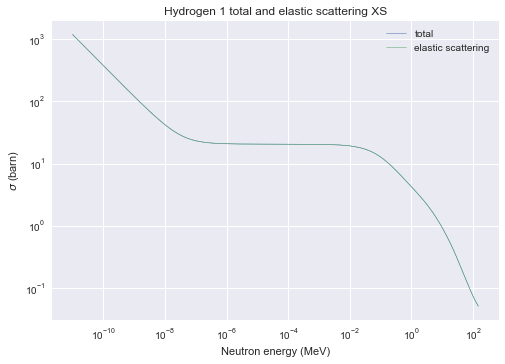

In [491]:
H1 = load_ace(1001)

plot_temperatures(H1, 1, xs_t,
                  title='Hydrogen 1 total XS',
                  save='H1')

plot_temperatures(H1, 2, xs_e,
                  title='Hydrogen 1 elastic scattering XS',
                  save='H1_MT2')

plot_temperatures(H1, 102, xs_gamma,
                  title='Hydrogen 1 capture XS',
                  save='H1_MT102')

In [ ]:
H1_3 = H1.tables['1001.03c']

plot_compare_mts(H1_3, (1,2), ('total','elastic scattering'),
                 title='Hydrogen 1 total and elastic scattering XS',
                 save='H1_MT1_MT2')

In [ ]:
SCR = H1_3.reactions[2].sigma/H1_3.reactions[102].sigma

plot_ratio(H1_3.energy, SCR,
           '$ \sigma_{\mathrm{e}} / \sigma_{\mathrm{c}} $ ',
           title='Hydrogen 1 elastic scattering to radiative capture ratio',
           save='H1_SCR',
           ylim=None)

mp = moderating_power(H1_mass, H1_3)

plot_xs(H1_3.energy, mp, 'Moderating power',
        title='Hydrogen 1 moderating power at 300 K',
        save='H1_MP')

mr = moderating_ratio(H1_mass, H1_3)

plot_xs(H1_3.energy, mr, 'Moderating ratio',
        title='Hydrogen 1 moderating ratio at 300 K',
        save='H1_MR')

Beryllium

In [ ]:
Be9 = load_ace(4009)
Be9_3 = Be9.tables['4009.03c']
Be9_3.reactions

plot_temperatures(Be9, 1, xs_t,
                  title='Beryllium 9 total XS',
                  save='Be9')

In [ ]:
plot_temperatures(Be9, 2, xs_e,
                  title='Beryllium 9 elastic scattering XS',
                  save='Be9_MT2')

In [ ]:
SCR = Be9_3.reactions[2].sigma/Be9_3.reactions[102].sigma

plot_ratio(Be9_3.energy, SCR,
           '$ \sigma_{\mathrm{e}} / \sigma_{\mathrm{c}} $ ',
           title='Beryllium 9 elastic scattering to radiative capture ratio',
           save='Be9_SCR',
           ylim=None)

mp = moderating_power(Be9_mass, Be9_3)

plot_xs(Be9_3.energy, mp, 'Moderating power',
        title='Beryllium 9 moderating power at 300 K',
        save='Be9_MP')

mr = moderating_ratio(Be9_mass, Be9_3)

plot_xs(Be9_3.energy, mr, 'Moderating ratio',
        title='Beryllium 9 moderating ratio at 300 K',
        save='Be9_MR')

Boron

In [ ]:
B10 = load_ace(5010)

plot_temperatures(B10, 1, xs_t,
                  title='Boron 10 total XS',
                  save='B10')

plot_temperatures(B10, 2, xs_e,
                  title='Boron 10 elastic scattering XS',
                  save='B10_MT2')

plot_temperatures(B10, 107, xs_alpha,
                  title='Boron 10 alpha production capture XS',
                  save='B10_MT107')

Carbon

In [ ]:
C12 = load_ace(6000)
C12_3 = C12.tables['6000.03c']
C12_3.reactions

plot_temperatures(C12, 1, xs_t,
                  title='Carbon 12 total XS',
                  save='C12')

plot_temperatures(C12, 2, xs_e,
                  title='Carbon 12 elastic scattering XS',
                  save='C12_MT2')

plot_temperatures(C12, 102, xs_gamma,
                  title='Carbon 12 capture XS',
                  save='C12_MT102')

In [ ]:
SCR = C12_3.reactions[2].sigma/C12_3.reactions[102].sigma

plot_ratio(C12_3.energy, SCR,
           '$ \sigma_{\mathrm{e}} / \sigma_{\mathrm{c}} $ ',
           title='Carbon 12 elastic scattering to radiative capture ratio',
           save='C12_SCR',
           ylim=None)

mp = moderating_power(C12_mass, C12_3)

plot_xs(C12_3.energy, mp, 'Moderating power',
        title='Carbon 12 moderating power at 300 K',
        save='C12_MP')

mr = moderating_ratio(C12_mass, C12_3)

plot_xs(C12_3.energy, mr, 'Moderating ratio',
        title='Carbon 12 moderating ratio at 300 K',
        save='C12_MR')

Oxygen

In [ ]:
O16 = load_ace(8016)

plot_temperatures(O16, 1, xs_t,
                  title='Oxygen 16 total XS',
                  save='O16')

plot_temperatures(O16, 2, xs_e,
                  title='Oxygen 16 elastic scattering XS',
                  save='O16_MT2')

plot_temperatures(O16, 102, xs_gamma,
                  title='Oxygen 16 capture XS',
                  save='O16_MT102')

In [ ]:
O16_3 = O16.tables['8016.03c']

plot_compare_mts(O16_3, (1,2), ('total','elastic scattering'),
                 title='Oxygen 16 total and elastic scattering XS',
                 save='O16_MT1_MT2')
